In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

# Unzip (adjust paths as needed)
!unzip coco_train2017.zip -d coco_train2017
!unzip coco_val2017.zip -d coco_val2017
!unzip coco_ann2017.zip -d coco_ann2017

--2025-05-14 13:28:42--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.29.154, 16.15.178.234, 3.5.28.199, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.29.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco_train2017.zip’

coco_train2017.zip   70%[=============>      ]  12.71G  16.9MB/s    eta 5m 50s 

############################################################################

In [2]:
from tensorflow import keras
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
import keras
from keras.layers import *
from keras.optimizers import *
import time
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import plot_model
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from pycocotools.coco import COCO

In [66]:
# Load paths for the COCO dataset annotation files
train_annotation_path = 'coco_ann2017/annotations/instances_train2017.json'
val_annotation_path = 'coco_ann2017/annotations/instances_val2017.json'

# Define the object classes of interest
classes = ['person']

# Initialize COCO instances for training set and load relevant data
coco_train = COCO(train_annotation_path)
catIds_train = coco_train.getCatIds(catNms=classes)
imgIds_train = coco_train.getImgIds(catIds=catIds_train)
imgDict_train = coco_train.loadImgs(imgIds_train)

# Initialize COCO instances for validation set and load relevant data
coco_val = COCO(val_annotation_path)
catIds_val = coco_val.getCatIds(catNms=classes)
imgIds_val = coco_val.getImgIds(catIds=catIds_val)
imgDict_val = coco_val.loadImgs(imgIds_val)

# Print the number of training and validation images and categories
print("number of training images: ", len(imgIds_train))
print("number of validation images: ",len(imgIds_val))

# Check the number of files in the validation images directory
print("total number of images in the training images directory :", len(os.listdir("coco_train2017/train2017/")))
print("total number of images in the validation images directory :", len(os.listdir("coco_val2017/val2017/")))

loading annotations into memory...
Done (t=15.88s)
creating index...
index created!
loading annotations into memory...
Done (t=2.27s)
creating index...
index created!
number of training images:  64115
number of validation images:  2693
total number of images in the training images directory : 118287
total number of images in the validation images directory : 5000


In [ ]:
# !rm -r mask_train_2017/*

In [5]:
# Create a directory for training masks
!mkdir mask_train_2017

# Generate the masks for training
for id in imgIds_train:

    file_path = "mask_train_2017/{0:012d}.jpg".format(id)

    #random image
    sampleImgIds = coco_train.getImgIds(imgIds=[id])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve annotations
    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    # Generate masks
    # annToMask() converts an individual annotation for one person into a binary mask.
    # The loop combines masks from all annotations in the image building a single full mask for all persons in the image
    mask = coco_train.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_train.annToMask(anns[i])

    # mask is currently a NumPy array with values 0 or 1.
    # Multiplying by 255 converts it to grayscale (0 for background, 255 for person)
    # "L" converts it to a PIL grayscale image
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)

# Create a directory for validation masks
!mkdir mask_val_2017

# Generate the masks for validation
for id in imgIds_val:

    file_path = "mask_val_2017/{0:012d}.jpg".format(id)

    # random image
    sampleImgIds = coco_val.getImgIds(imgIds=[id])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve annotations
    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    # Generate masks
    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_val.annToMask(anns[i])

    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)

mkdir: cannot create directory ‘mask_train_2017’: File exists


In [6]:
class DataPreprocess(keras.utils.Sequence):
    def __init__(self, images_path, masks_path, batch_size, image_size=(128, 128)):
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.filenames = self._get_matching_filenames()

    def _get_matching_filenames(self):
        image_ids = {os.path.splitext(f)[0] for f in os.listdir(self.images_path)}
        mask_ids = {os.path.splitext(f)[0] for f in os.listdir(self.masks_path)}
        return sorted(list(image_ids & mask_ids))  # Sorted for consistent order

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for file_id in batch_files:
            img = self._load_image(os.path.join(self.images_path, file_id + '.jpg'))
            mask = self._load_mask(os.path.join(self.masks_path, file_id + '.jpg'))

            if img.shape != (self.image_size[0], self.image_size[1], 3):
                continue  # Skip invalid images

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def _load_image(self, path):
        img = Image.open(path).resize(self.image_size)
        img_array = np.array(img).astype('float32') / 255.0
        return img_array

    def _load_mask(self, path):
        mask = Image.open(path).resize(self.image_size)
        mask_array = np.array(mask).astype('float32') / 255.0
        return mask_array

images_path_train = 'coco_train2017/train2017/'
masks_path_train = 'mask_train_2017/'
batch_size = 8

train_generator = DataPreprocess(images_path_train, masks_path_train, batch_size)

images_path_val = 'coco_val2017/val2017/'
masks_path_val = 'mask_val_2017/'
batch_size = 8

val_generator = DataPreprocess(images_path_val, masks_path_val, batch_size)

In [7]:
print(len(train_generator))
print(len(val_generator))

8015
337


Mask Image Shape: (640, 426)
Main Image Shape: (640, 426, 3)


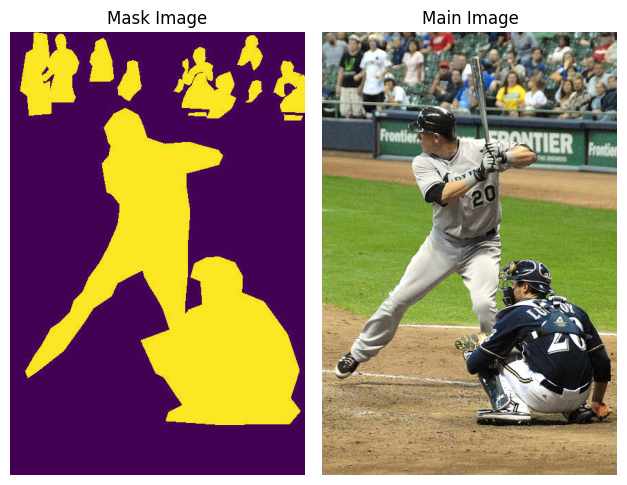

In [17]:
# Get the list of mask filenames
mask_filenames = [filename for filename in os.listdir(masks_path_val) if filename.endswith('.jpg')]

# Assuming the first image in the mask folder is the one to plot
first_mask_filename = mask_filenames[3]
image_filename = os.path.splitext(first_mask_filename)[0] + '.jpg'

# Load and plot the mask image
mask_image = Image.open(os.path.join(masks_path_val, first_mask_filename))
plt.subplot(1, 2, 1)
plt.imshow(mask_image)
plt.title('Mask Image')
plt.axis('off')

# Load and plot the corresponding main image
main_image = Image.open(os.path.join(images_path_val, image_filename))
plt.subplot(1, 2, 2)
plt.imshow(main_image)
plt.title('Main Image')
plt.axis('off')

# Print the shapes of the images
print('Mask Image Shape:', np.array(mask_image).shape)
print('Main Image Shape:', np.array(main_image).shape)

plt.tight_layout()
plt.show()

In [38]:
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

# Down 1
c1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
c1 = BatchNormalization(scale=True)(c1)
c1 = Activation('relu')(c1)
c1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(c1)
c1 = BatchNormalization(scale=True)(c1)
c1 = Activation('relu')(c1)
p1 = MaxPooling2D((2, 2))(c1)

# Down 2
c2 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(p1)
c2 = BatchNormalization(scale=True)(c2)
c2 = Activation('relu')(c2)
c2 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(c2)
c2 = BatchNormalization(scale=True)(c2)
c2 = Activation('relu')(c2)
p2 = MaxPooling2D((2, 2))(c2)

# Down 3
c3 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(p2)
c3 = BatchNormalization(scale=True)(c3)
c3 = Activation('relu')(c3)
c3 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(c3)
c3 = BatchNormalization(scale=True)(c3)
c3 = Activation('relu')(c3)
p3 = MaxPooling2D((2, 2))(c3)

# Down 4
c4 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(p3)
c4 = BatchNormalization(scale=True)(c4)
c4 = Activation('relu')(c4)
c4 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(c4)
c4 = BatchNormalization(scale=True)(c4)
c4 = Activation('relu')(c4)
p4 = MaxPooling2D((2, 2))(c4)

# Bottleneck
c5 = Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_normal')(p4)
c5 = BatchNormalization(scale=True)(c5)
c5 = Activation('relu')(c5)
c5 = Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_normal')(c5)
c5 = BatchNormalization(scale=True)(c5)
c5 = Activation('relu')(c5)

# Up 4
u4 = UpSampling2D((2, 2))(c5)
u4 = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal')(u4)
u4 = BatchNormalization(scale=True)(u4)
u4 = Activation('relu')(u4)
u4 = concatenate([c4, u4])
u4 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(u4)
u4 = BatchNormalization(scale=True)(u4)
u4 = Activation('relu')(u4)
u4 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(u4)
u4 = BatchNormalization(scale=True)(u4)
u4 = Activation('relu')(u4)

# Up 3
u3 = UpSampling2D((2, 2))(u4)
u3 = Conv2D(256, (2, 2), padding='same', kernel_initializer='he_normal')(u3)
u3 = BatchNormalization(scale=True)(u3)
u3 = Activation('relu')(u3)
u3 = concatenate([c3, u3])
u3 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(u3)
u3 = BatchNormalization(scale=True)(u3)
u3 = Activation('relu')(u3)
u3 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(u3)
u3 = BatchNormalization(scale=True)(u3)
u3 = Activation('relu')(u3)

# Up 2
u2 = UpSampling2D((2, 2))(u3)
u2 = Conv2D(128, (2, 2), padding='same', kernel_initializer='he_normal')(u2)
u2 = BatchNormalization(scale=True)(u2)
u2 = Activation('relu')(u2)
u2 = concatenate([c2, u2])
u2 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(u2)
u2 = BatchNormalization(scale=True)(u2)
u2 = Activation('relu')(u2)
u2 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(u2)
u2 = BatchNormalization(scale=True)(u2)
u2 = Activation('relu')(u2)

# Up 1
u1 = UpSampling2D((2, 2))(u2)
u1 = Conv2D(64, (2, 2), padding='same', kernel_initializer='he_normal')(u1)
u1 = BatchNormalization(scale=True)(u1)
u1 = Activation('relu')(u1)
u1 = concatenate([c1, u1])
u1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(u1)
u1 = BatchNormalization(scale=True)(u1)
u1 = Activation('relu')(u1)
u1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(u1)
u1 = BatchNormalization(scale=True)(u1)
u1 = Activation('relu')(u1)

# Output
output = Conv2D(2, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu')(u1)
output = Conv2D(1, (1, 1), activation='sigmoid')(output)

# Model
model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
model.summary()
plot_model(model, to_file='unet_architecture.png', show_shapes=True)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_144[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_132      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_145 (Conv2D) │ (None, 128, 128,  │     36,928 │ activation_132[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_145[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_133      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 64, 64,    │          0 │ activation_133[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_146 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_24… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_146[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_134      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 64, 64,    │    147,584 │ activation_134[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_147[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_135      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 32, 32,    │          0 │ activation_135[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_25… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_148[0][0]

 Total params: 31,060,229 (118.49 MB)

 Trainable params: 31,046,533 (118.43 MB)

 Non-trainable params: 13,696 (53.50 KB)

In [40]:
import subprocess

def log_gpu_info():
    try:
        print("=== GPU & VRAM INFO ===")
        result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
        print(result.stdout.decode('utf-8'))
    except Exception as e:
        print(f"Could not retrieve GPU info: {e}")

# Log before training
log_gpu_info()

=== GPU & VRAM INFO ===
Tue May 13 20:23:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   75C    P0             34W /   72W |    1213MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------

In [41]:
log_gpu_info()

train_steps =  int(len(os.listdir( "mask_train_2017/"))/batch_size)
print(train_steps)
# Estimate training time and memory
start_time = time.time()
history = model.fit(train_generator,validation_data = val_generator, steps_per_epoch = train_steps , epochs=20)
end_time = time.time()
training_duration = end_time - start_time

print(f"\n🕒 Training Time: {training_duration:.2f} seconds")
print(f"🧠 Total Trainable Parameters: {model.count_params():,}")
print(f"📦 Estimated Memory Use: ~{model.count_params() * 4 / (1024**2):.2f} MB")
log_gpu_info()


=== GPU & VRAM INFO ===
Tue May 13 20:23:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   76C    P0             34W /   72W |    1213MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8014/8014 ━━━━━━━━━━━━━━━━━━━━ 680s 80ms/step - accuracy: 0.8196 - loss: 0.6352 - val_accuracy: 0.8636 - val_loss: 0.4641
Epoch 2/20
   1/8014 ━━━━━━━━━━━━━━━━━━━━ 9:00 67ms/step - accuracy: 0.9331 - loss: 0.4113

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8014/8014 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9331 - loss: 0.4113 - val_accuracy: 0.8641 - val_loss: 0.4636
Epoch 3/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 602s 75ms/step - accuracy: 0.8772 - loss: 0.4162 - val_accuracy: 0.8925 - val_loss: 0.3131
Epoch 4/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8958 - loss: 0.3033 - val_accuracy: 0.8927 - val_loss: 0.3128
Epoch 5/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 598s 75ms/step - accuracy: 0.8964 - loss: 0.2873 - val_accuracy: 0.9018 - val_loss: 0.2332
Epoch 6/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9045 - loss: 0.2118 - val_accuracy: 0.9017 - val_loss: 0.2333
Epoch 7/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 598s 75ms/step - accuracy: 0.9062 - loss: 0.2170 - val_accuracy: 0.9054 - val_loss: 0.2004
Epoch 8/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8908 - loss: 0.2138 - val_accuracy: 0.9058 - val_loss: 0.1991
Epoch 9/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 598s 75ms/step - accuracy: 0.9122 - loss: 0.17

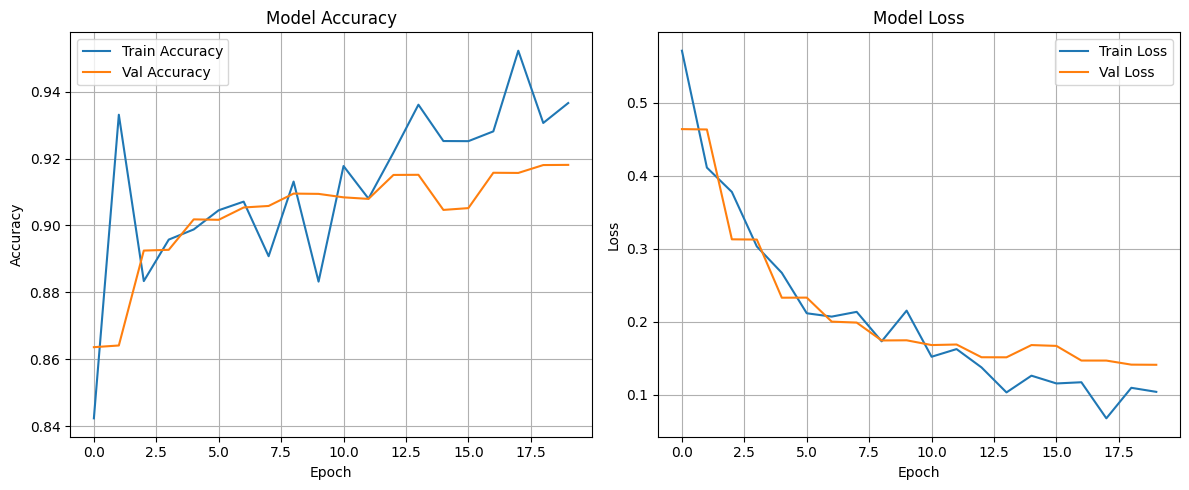

In [55]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


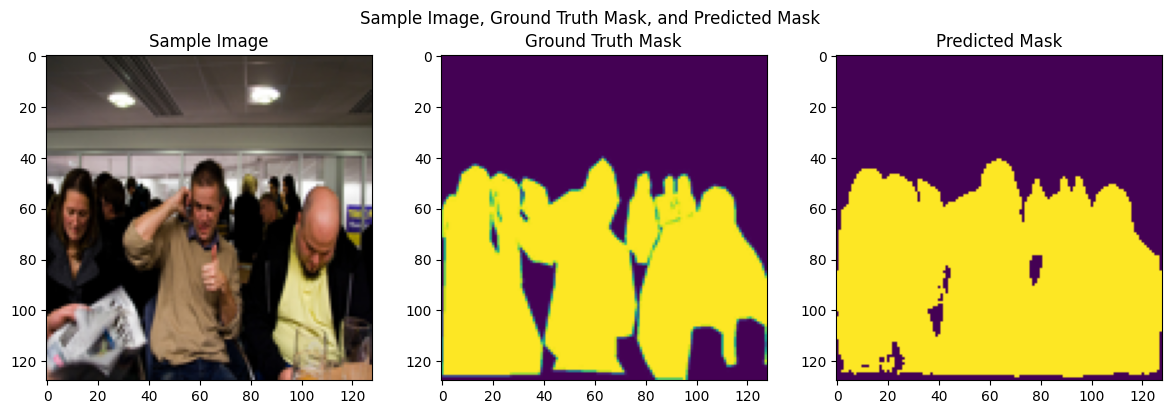

In [50]:
# Get a sample batch from the validation data generator
sample_images, sample_masks = val_generator[0]

# Generate predictions on the sample batch
predictions = model.predict(sample_images)

# Threshold the predictions (if needed)
threshold = 0.5  # Adjust the threshold as per your requirement
thresholded_predictions = (predictions > threshold).astype(np.uint8)

# Select a random index from the batch
idx = np.random.randint(0, sample_images.shape[0])

# Plot the sample image, ground truth mask, and predicted mask
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot sample image
axes[0].imshow(sample_images[idx])
axes[0].set_title('Sample Image')

# Plot ground truth mask
axes[1].imshow(sample_masks[idx])
axes[1].set_title('Ground Truth Mask')

# Plot predicted mask
axes[2].imshow(thresholded_predictions[idx])
axes[2].set_title('Predicted Mask')

# Set common title for the figure
fig.suptitle('Sample Image, Ground Truth Mask, and Predicted Mask')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [52]:
from tensorflow.keras.metrics import MeanIoU

y_pred = model.predict(sample_images)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

idx = np.random.randint(0, sample_images.shape[0])

iou_metric = MeanIoU(num_classes=2)

# Loop through the entire validation generator
for i in range(len(val_generator)):
    # Get a batch of validation data
    val_images, val_masks = val_generator[i]

    # Make predictions
    preds = model.predict(val_images)

    # Threshold the predictions to binary masks
    preds_thresholded = (preds > 0.5).astype(np.int32)  # You can change threshold if needed

    # Convert ground truths to int if needed
    val_masks_int = val_masks.astype(np.int32)

    # Update the MeanIoU metric with current batch
    iou_metric.update_state(val_masks_int, preds_thresholded)

# Retrieve final IoU score
mean_iou_result = iou_metric.result().numpy()
print(f"\n📊 Mean IoU: {mean_iou_result:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

In [57]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files

# === 1. Save the trained model ===
# You should do this after training (you can insert this after model.fit in your script)
model.save('unet_coco_person_segmentation2.h5')  # Saves the model architecture, weights, and optimizer
model.save('my_model2.keras')

# === 2. Load the model for inference ===

files.download("my_model2.keras")
files.download('unet_coco_person_segmentation2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


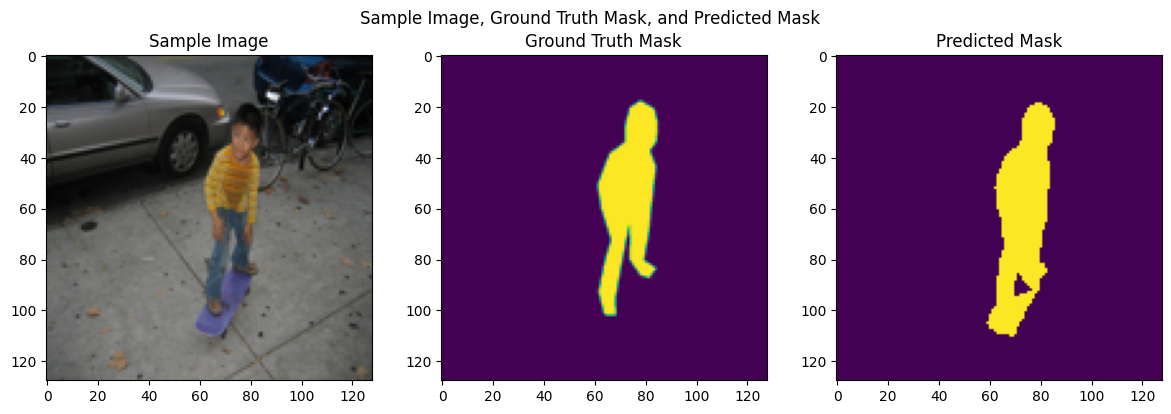

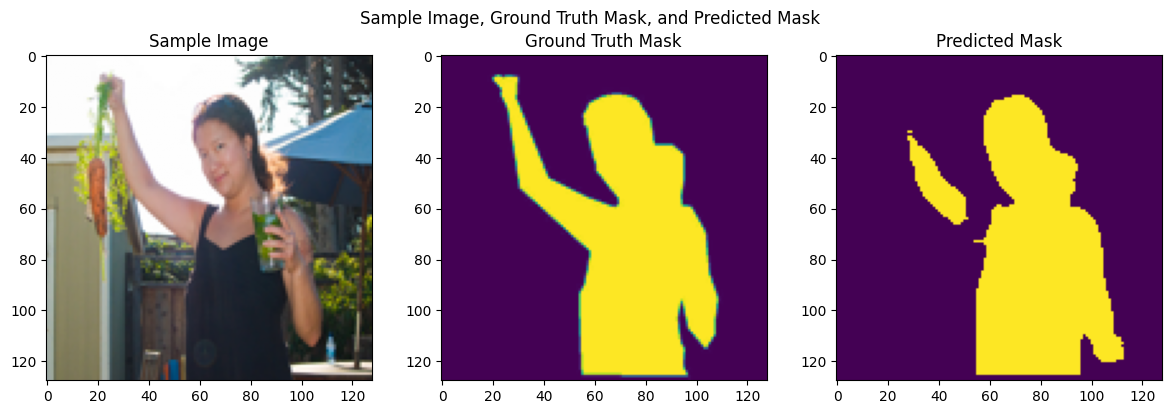

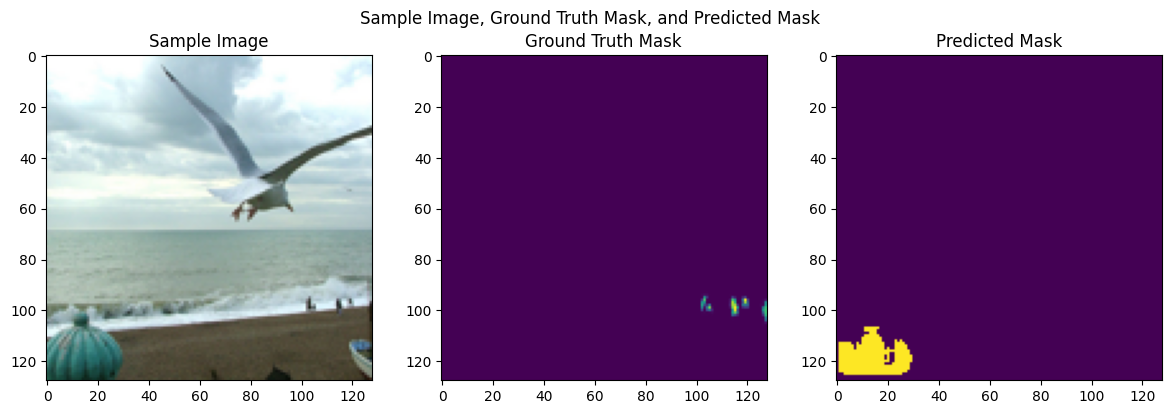

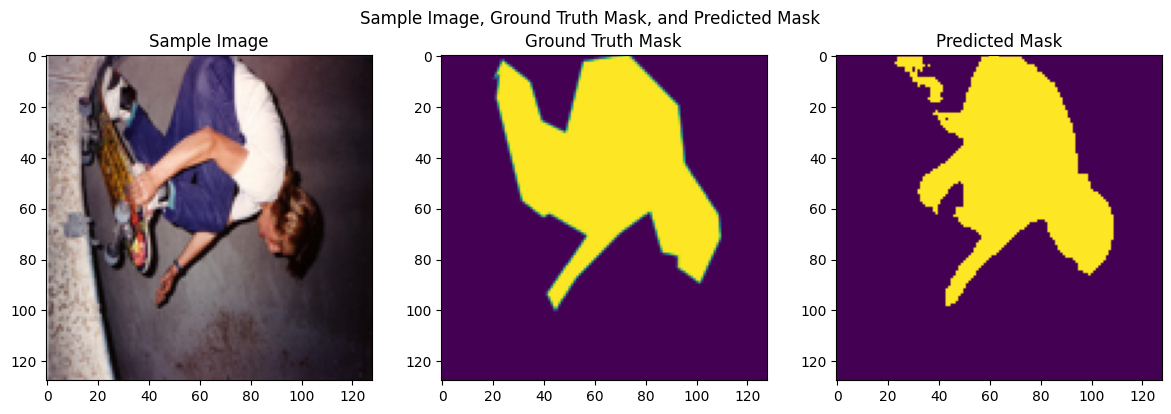

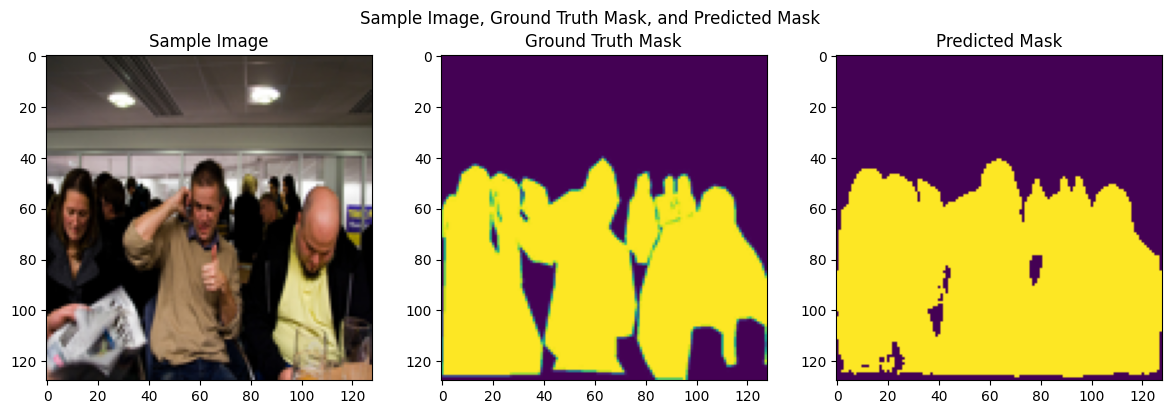

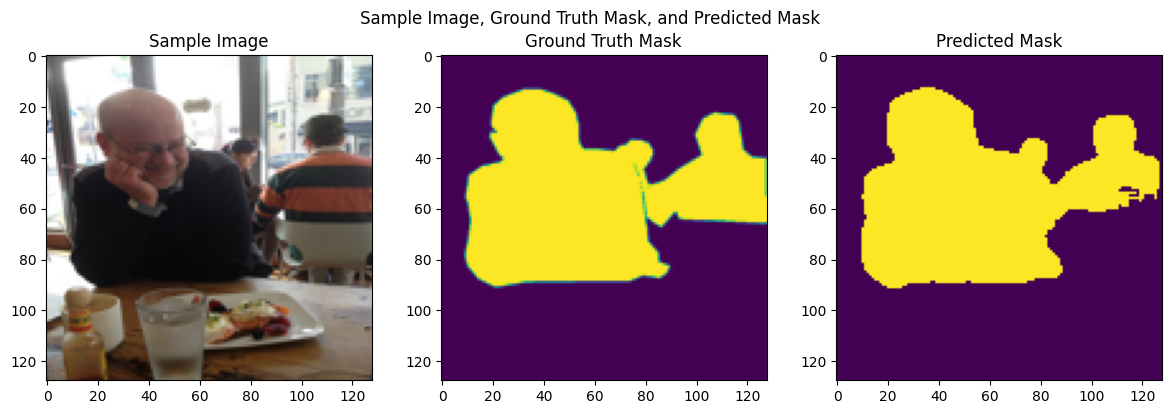

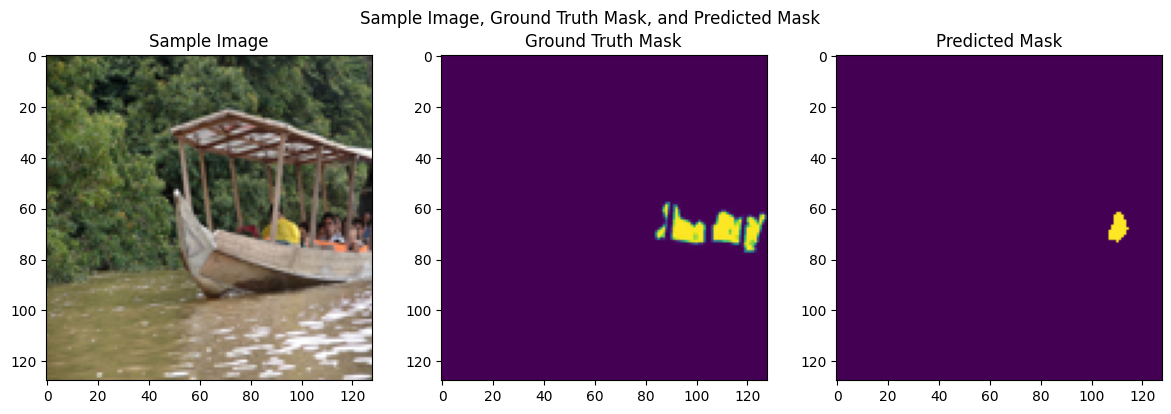

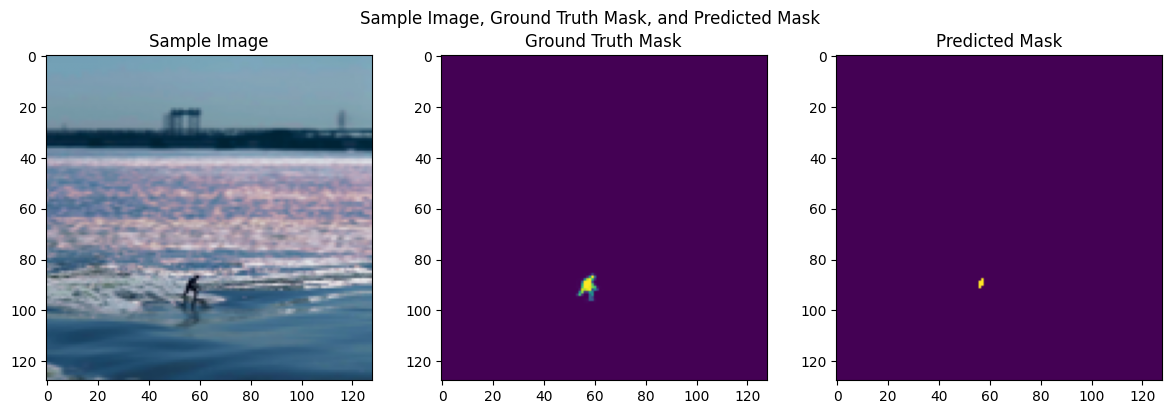

In [62]:
inference_model = load_model('my_model2.keras')

# Get a sample batch from the validation data generator
sample_images, sample_masks = val_generator[0]

# Generate predictions on the sample batch
predictions = inference_model.predict(sample_images)

# Threshold the predictions (if needed)
threshold = 0.5  # Adjust the threshold as per your requirement
thresholded_predictions = (predictions > threshold).astype(np.uint8)

# Select a random index from the batch
# idx = np.random.randint(0, sample_images.shape[0])

for idx in range(0, len(sample_images)):
  # Plot the sample image, ground truth mask, and predicted mask
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  # Plot sample image
  axes[0].imshow(sample_images[idx])
  axes[0].set_title('Sample Image')

  # Plot ground truth mask
  axes[1].imshow(sample_masks[idx])
  axes[1].set_title('Ground Truth Mask')

  # Plot predicted mask
  axes[2].imshow(thresholded_predictions[idx])
  axes[2].set_title('Predicted Mask')

  # Set common title for the figure
  fig.suptitle('Sample Image, Ground Truth Mask, and Predicted Mask')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the figure
  plt.show()